## Import packages

In [6]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from rasterio.plot import show
from datetime import datetime, timedelta

import pandas as pd
import rasterio
import glob
import os

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


## Import the tabular data

In [7]:
# buffalo_id = 2005
# n_samples = 10297 # 2005 has 10297 samples

# buffalo_id = 2018
# n_samples = 9440 # 2018 has 9440 samples

buffalo_id = 2039
n_samples = 5569

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  20933.723353 -1.431737e+06  2018-07-25T01:09:06Z  2039  20933.723353   
1  20808.442429 -1.431755e+06  2018-07-25T02:09:10Z  2039  20808.442429   
2  20961.795005 -1.431730e+06  2018-07-25T03:09:35Z  2039  20961.795005   
3  20954.532773 -1.431724e+06  2018-07-25T04:09:02Z  2039  20954.532773   
4  21149.850466 -1.431695e+06  2018-07-25T05:09:30Z  2039  21149.850466   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.431737e+06  20808.442429 -1.431755e+06 -125.280925 -17.927868  ...   
1 -1.431755e+06  20961.795005 -1.431730e+06  153.352576  24.883532  ...   
2 -1.431730e+06  20954.532773 -1.431724e+06   -7.262232   5.575306  ...   
3 -1.431724e+06  21149.850466 -1.431695e+06  195.317693  28.712346  ...   
4 -1.431695e+06  21189.076273 -1.431711e+06   39.225807 -16.109380  ...   

  bearing_sin  bearing_cos        ta    cos_ta         x_min         x_max  \
0   -0.141658    -0.

## Importing spatial data

## Sentinel-2 bands

Each stack represents a month of median values of cloud-free pixels, and each layer in the stack are the bands.


In [8]:
# Step 1: Specify the directory containing your TIFF files
data_dir = '../mapping/cropped rasters/sentinel2/25m'  # Replace with the actual path to your TIFF files

# Step 2: Use glob to get a list of all TIFF files matching the pattern
tif_files = glob.glob(os.path.join(data_dir, 'S2_SR_masked_25m_*.tif')) 
print(f'Found {len(tif_files)} TIFF files')
print('\n'.join(tif_files))

Found 12 TIFF files
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_01.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_02.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_03.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_04.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_05.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_06.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_07.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_08.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_09.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_10.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_11.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_12.tif


In [9]:
# Step 3: Initialize a dictionary to store data with date as the key
data_dict = {}

# Step 4: Define the min and max values for normalization for each band
# Values are from the buffalo 2005 local layers
band_normalization = {
              "Band1": {"min": 1.0, "max": 1517.0848},
              "Band2": {"min": 28.1072, "max": 1931.7552},
              "Band3": {"min": 210.9864, "max": 2795.7568},
              "Band4": {"min": 65.7832, "max": 4386.7969},
              "Band5": {"min": 358.7600, "max": 4592.7358},
              "Band6": {"min": 385.3400, "max": 5120.9146},
              "Band7": {"min": 416.5744, "max": 6045.6992},
              "Band8": {"min": 368.0320, "max": 6004.5825},
              "Band8a": {"min": 357.0704, "max": 6218.4136},
              "Band9": {"min": 123.0, "max": 5680.5000},
              "Band11": {"min": 174.1200, "max": 6570.3921},
              "Band12": {"min": 123.3760, "max": 5119.9966}
}

# # Define the min and max values for normalization for each band - when all scaled by 10000
# band_normalization = {
#     "Band1": {"min": 0.0, "max": 10000.0},
#     "Band2": {"min": 0.0, "max": 10000.0},
#     "Band3": {"min": 0.0, "max": 10000.0},
#     "Band4": {"min": 0.0, "max": 10000.0},
#     "Band5": {"min": 0.0, "max": 10000.0},
#     "Band6": {"min": 0.0, "max": 10000.0},
#     "Band7": {"min": 0.0, "max": 10000.0},
#     "Band8": {"min": 0.0, "max": 10000.0},
#     "Band8a": {"min": 0.0, "max": 10000.0},
#     "Band9": {"min": 0.0, "max": 10000.0},
#     "Band11": {"min": 0.0, "max": 10000.0},
#     "Band12": {"min": 0.0, "max": 10000.0}
# }

print(band_normalization)

{'Band1': {'min': 1.0, 'max': 1517.0848}, 'Band2': {'min': 28.1072, 'max': 1931.7552}, 'Band3': {'min': 210.9864, 'max': 2795.7568}, 'Band4': {'min': 65.7832, 'max': 4386.7969}, 'Band5': {'min': 358.76, 'max': 4592.7358}, 'Band6': {'min': 385.34, 'max': 5120.9146}, 'Band7': {'min': 416.5744, 'max': 6045.6992}, 'Band8': {'min': 368.032, 'max': 6004.5825}, 'Band8a': {'min': 357.0704, 'max': 6218.4136}, 'Band9': {'min': 123.0, 'max': 5680.5}, 'Band11': {'min': 174.12, 'max': 6570.3921}, 'Band12': {'min': 123.376, 'max': 5119.9966}}


In [10]:
# Step 5: Loop over each TIFF file to read and process the data
for tif_file in tif_files:
    # Extract the filename from the path
    filename = os.path.basename(tif_file)
    
    # Extract the date from the filename
    # Assuming filenames are in the format 'S2_SR_masked_YYYY_MM.tif'
    date_str = filename.replace('S2_SR_masked_25m_', '').replace('.tif', '')
    # date_str will be something like '2019_01'
    
    # Read the TIFF file using rasterio
    with rasterio.open(tif_file) as src:
        # Read all bands of the TIFF file
        data = src.read()
        # 'data' is a NumPy array with shape (bands, height, width)
        
        # Initialize an array to store normalized data
        normalized_data = np.zeros_like(data, dtype=np.float32)
        
        # Loop over each band to perform normalization
        for i, (band_name, values) in enumerate(band_normalization.items()):
            # Get the data for the current band
            band_data = data[i]
            
            # Get the corresponding min and max values for this band
            band_min = values['min']
            band_max = values['max']

            # Replace NaN values in the original data with the band minimum
            band_data = np.nan_to_num(band_data, nan=band_min)
            
            # Perform min-max normalization to scale data between 0 and 1
            # Avoid division by zero by checking if (max - min) is not zero
            if band_max - band_min != 0:
                normalized_band = (band_data - band_min) / (band_max - band_min)
            else:
                # If max and min are the same, set normalized data to zero
                normalized_band = np.zeros_like(band_data, dtype=np.float32)
            
            # Store the normalized band data
            normalized_data[i] = normalized_band

            # Check the normalization for the current band
            print(f"Band {i + 1} of {date_str}:")
            print(f"Original min: {band_data.min()}, Original max: {band_data.max()}")
            print(f"Normalized min: {normalized_band.min()}, Normalized max: {normalized_band.max()}")
            print("-" * 50)

            # # Plot the first few layers (bands) for visualization
            # if i < 3:  # Change the number of bands you want to plot by adjusting this condition
            #     plt.figure(figsize=(8, 6))
            #     plt.imshow(normalized_band, cmap='viridis')  # You can change the colormap as needed
            #     plt.colorbar() # label='Normalized Value'
            #     plt.title(f'Band {i + 1} - {date_str}')
            #     plt.show()
        
        # Add the normalized data to the dictionary with date as the key
        data_dict[date_str] = normalized_data

Band 1 of 2019_01:
Original min: 1.0, Original max: 3130.509521484375
Normalized min: 0.0, Normalized max: 2.064204692840576
--------------------------------------------------
Band 2 of 2019_01:
Original min: 28.107200622558594, Original max: 4062.55517578125
Normalized min: 0.0, Normalized max: 2.1193246841430664
--------------------------------------------------
Band 3 of 2019_01:
Original min: 106.44960021972656, Original max: 4883.92333984375
Normalized min: -0.040443360805511475, Normalized max: 1.8078731298446655
--------------------------------------------------
Band 4 of 2019_01:
Original min: 65.783203125, Original max: 5488.09619140625
Normalized min: 0.0, Normalized max: 1.2548705339431763
--------------------------------------------------
Band 5 of 2019_01:
Original min: 120.79679870605469, Original max: 5836.35107421875
Normalized min: -0.05620325356721878, Normalized max: 1.2937228679656982
--------------------------------------------------
Band 6 of 2019_01:
Original min

KeyboardInterrupt: 

In [5]:
# Step 6: Select some bands from the processed data stored in 'data_dict' for plotting
layers_to_plot = []

# Specify the date and band numbers you want to plot
dates_to_plot = ['2019_01', '2019_05']  # This grabs all available dates. You can select specific ones if needed.
bands_to_plot = [1, 2, 3]  # Band indices for bands 2, 3, and 4, which are B, G, and R

# Loop through the selected dates and bands to prepare them for plotting
for date_str in dates_to_plot:
    normalized_data = data_dict[date_str]  # Get the normalized data for this date
    
    for band_idx in bands_to_plot:
        # Collect the specific band for plotting
        layers_to_plot.append((normalized_data[band_idx], band_idx + 1, date_str))

# random layers to test plotting function
# layers_to_plot = [
#     (np.random.rand(100, 100), 1, '2023-01-01'),
#     (np.random.rand(100, 100), 2, '2023-02-01'),
#     (np.random.rand(100, 100), 3, '2023-03-01')
# ]

# Step 7: Plot the stored layers
for normalized_band, band_number, date_str in layers_to_plot:
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_band, cmap='viridis') 
    plt.title(f'Band {band_number} - {date_str}')
    plt.colorbar() #label='Normalized Value'
    plt.show()


KeyError: '2019_01'

### NDVI

In [8]:
# file_path = '../mapping/cropped rasters/ndvi_2018-19_late_dry.tif'
# file_path_ndvi_aug2018 = '../mapping/cropped rasters/ndvi_aug_2018.tif'
# file_path_ndvi_feb2019 = '../mapping/cropped rasters/ndvi_feb_2019.tif'

# # read the raster file
# with rasterio.open(file_path) as src:
#     # Read the raster band as separate variable
#     ndvi_global = src.read(1)
#     # Get the metadata of the raster
#     ndvi_meta = src.meta
#     raster_transform = src.transform

# with rasterio.open(file_path_ndvi_aug2018) as src:
#     # Read the raster band as separate variable
#     ndvi_aug2018 = src.read(1)
#     # Get the metadata of the raster
#     ndvi_meta_aug2018 = src.meta

# with rasterio.open(file_path_ndvi_feb2019) as src:
#     # Read the raster band as separate variable
#     ndvi_feb2019 = src.read(1)
#     # Get the metadata of the raster
#     ndvi_meta_feb2019 = src.meta


In [9]:
# print(ndvi_meta)
# print(raster_transform)
# print(ndvi_global.shape)

# # Replace NaNs in the original array with -1, which represents water
# ndvi_global = np.nan_to_num(ndvi_global, nan=-1.0)
# ndvi_aug2018 = np.nan_to_num(ndvi_aug2018, nan=-1.0)
# ndvi_feb2019 = np.nan_to_num(ndvi_feb2019, nan=-1.0)

# # create water mask
# water_mask = ndvi_global == -1.0

# # from the stack of local layers
# ndvi_max = 0.8220
# ndvi_min = -0.2772

# ndvi_global_tens = torch.from_numpy(ndvi_global)
# ndvi_aug2018_tens = torch.from_numpy(ndvi_aug2018)
# ndvi_feb2019_tens = torch.from_numpy(ndvi_feb2019)

# # Normalizing the data
# ndvi_global_norm = (ndvi_global_tens - ndvi_min) / (ndvi_max - ndvi_min)
# ndvi_aug2018_norm = (ndvi_aug2018_tens - ndvi_min) / (ndvi_max - ndvi_min)
# ndvi_feb2019_norm = (ndvi_feb2019_tens - ndvi_min) / (ndvi_max - ndvi_min)

# plt.imshow(ndvi_global_norm.numpy())
# plt.colorbar()  
# plt.show()

# plt.imshow(ndvi_aug2018_norm.numpy())
# plt.colorbar()
# plt.show()

# plt.imshow(ndvi_feb2019_norm.numpy())
# plt.colorbar()
# plt.show()


### Canopy cover

In [10]:
# file_path = '../mapping/cropped rasters/canopy_cover.tif'
# # read the raster file
# with rasterio.open(file_path) as src:
#     # Read the raster band as separate variable
#     canopy_global = src.read(1)
#     # Get the metadata of the raster
#     canopy_meta = src.meta


In [11]:
# print(canopy_meta)
# print(canopy_global.shape)

# # from the stack of local layers
# canopy_max = 82.5000
# canopy_min = 0.0

# canopy_global_tens = torch.from_numpy(canopy_global)

# # Normalizing the data
# canopy_global_norm = (canopy_global_tens - canopy_min) / (canopy_max - canopy_min)

# plt.imshow(canopy_global_norm.numpy())
# plt.colorbar()  
# plt.show()


### Herbaceous vegetation

In [12]:
# file_path = '../mapping/cropped rasters/veg_herby.tif'
# # read the raster file
# with rasterio.open(file_path) as src:
#     # Read the raster band as separate variable
#     herby_global = src.read(1)
#     # Get the metadata of the raster
#     herby_meta = src.meta


In [13]:
# print(herby_meta)
# print(herby_global.shape)

# # from the stack of local layers
# herby_max = 1.0
# herby_min = 0.0

# herby_global_tens = torch.from_numpy(herby_global)

# # Normalizing the data
# herby_global_norm = (herby_global_tens - herby_min) / (herby_max - herby_min)

# plt.imshow(herby_global_norm.numpy())
# plt.colorbar()  
# plt.show()


### Slope

In [14]:
file_path = '../mapping/cropped rasters/slope.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_global = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    raster_transform = src.transform # same as the raster transform in the NDVI raster read

print(slope_global)
print(raster_transform)


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 0.3352837  0.39781624 ... 0.         0.                nan]
 [       nan 0.3983888  0.48142004 ... 0.         0.                nan]
 ...
 [       nan 2.215875   1.9798415  ... 1.5078747  1.268342          nan]
 [       nan 1.9740707  1.7354656  ... 1.697194   1.4880029         nan]
 [       nan        nan        nan ...        nan        nan        nan]]
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


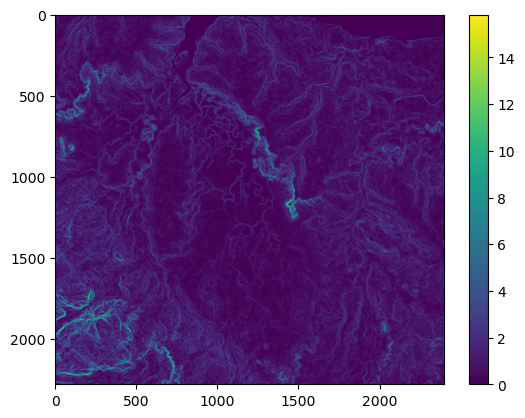

In [15]:
print(slope_meta)
print(slope_global.shape)

# Replace NaNs in the original array with -1, which represents water
slope_global = np.nan_to_num(slope_global, nan=0.0)

# from the stack of local layers
slope_max = 12.2981
slope_min = 0.0006

slope_global_tens = torch.from_numpy(slope_global)

# Normalizing the data
slope_global_norm = (slope_global_tens - slope_min) / (slope_max - slope_min)

plt.imshow(slope_global_tens.numpy())
plt.colorbar()  
plt.show()


Testing functions for selecting subsets of the raster layer, using torch objects

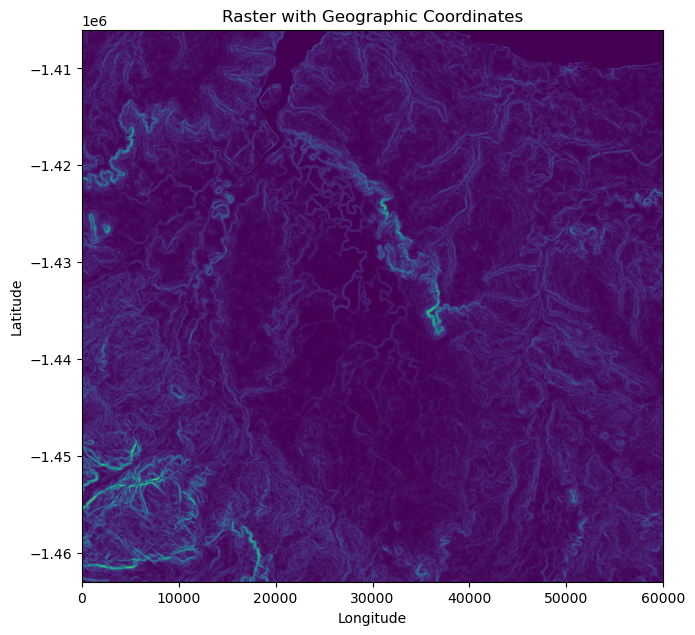

In [16]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Plot the raster
show(slope_global, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [17]:
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

59000.0 -1447000.0
2360 1640


# Running the model on the layers

### Set the device for the model

In [18]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Define the model

In [19]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)


class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)

        # normalise before combining with the movement grid
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)

        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )

    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )

    def forward(self, x):
        return self.ffn(x)

class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )

    def forward(self, x):
        return self.ffn(x)



##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters allowed to vary
##################################################

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        # self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### to transform the scale parameter to be near 1
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        # gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)

        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        bearing_new1 = x[:, 6] + bearing[:, 0]
        # bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]
        # bearing_new2 = torch.pi + bearing[:, 0]
        # bearing_new2 = -torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # normalise so the densities sum to 1 when exponentiated
        # vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        # normalise before combining with the habitat predictions
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)

        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid


class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x

        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output


class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [20]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 13 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

In [21]:
# date of the trained model checkpoint
date = '2024-10-24'

# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_CNN_S2_slope_buffalo{buffalo_id}_{date}.pt', weights_only=True, map_location=torch.device('cpu')))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Run CNN component on landscape

## Select a smaller extent of the landscape

In [22]:
# from the buffalo data
buffer = 1250
min_x = min(buffalo_df['x_']) - buffer
max_x = max(buffalo_df['x_']) + buffer
min_y = min(buffalo_df['y_']) - buffer
max_y = max(buffalo_df['y_']) + buffer

# custom extent
# min_x = 28148.969145
# max_x = 47719.496935
# min_y = -1442210.335861
# max_y = -1433133.681746

# Convert geographic coordinates to pixel coordinates
min_px, min_py = ~raster_transform * (min_x, min_y)
print(min_px, min_py)
max_px, max_py = ~raster_transform * (max_x, max_y)
print(max_px, max_py)
# Round pixel coordinates to integers
min_px, max_px, min_py, max_py = int(round(min_px)), int(round(max_px)), int(round(min_py)), int(round(max_py))

# Print the pixel coordinates	
print(min_px, max_px, min_py, max_py)


1091.3389860694217 1546.6350942641802
2166.104503472696 888.6517715825685
1091 2166 1547 889


### Use the day of the year to select a stack of Sentinel 2 bands

In [23]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2019, 1, 1)
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    # month_index = (date.month - 1) + (year_diff * 12)  # month index (0-based, accounting for year change)
    month_index = (date.month) + (year_diff * 12)  # month index (1-based)
    return month_index



In [37]:
yday = 50
month_index = day_to_month_index(yday) 
print(month_index)

# for sentinel 2 data
selected_month = f'2019_{month_index:02d}'
# Get the normalized data for the selected month
sentinel_layers = data_dict[selected_month]
print(sentinel_layers.shape)

2
(12, 2280, 2400)


## Subset all layers

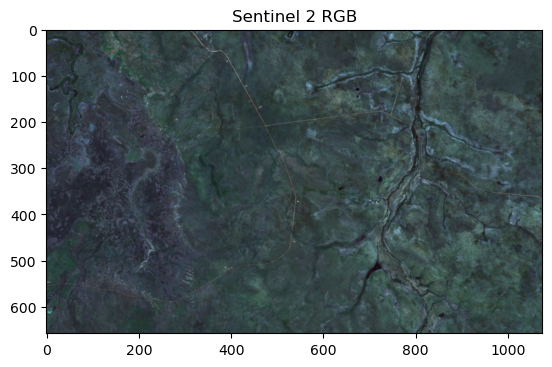

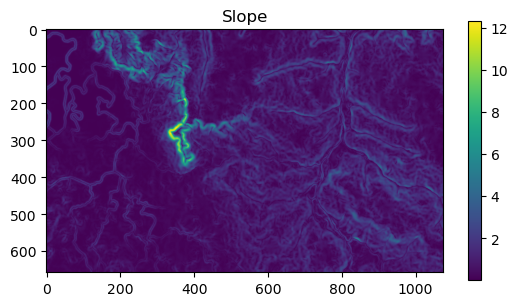

In [38]:
# Initialize the subset array with zeros (or any other padding value)
# subset = np.zeros((max_px - min_px, min_py - max_py), dtype=slope_global.dtype)
subset = np.zeros((min_py - max_py, max_px - min_px), dtype=slope_global.dtype)


# Initialize a list to store the results
layer_subsets = []

# Loop over each layer in sentinel_layers and global_raster_tensors
for sentinel_layer in sentinel_layers:
    # Process the sentinel layer
    sentinel_layer = torch.from_numpy(sentinel_layer)
    # print(sentinel_layer.shape)
    sentinel_result = sentinel_layer[max_py:min_py, min_px:max_px]
    layer_subsets.append(sentinel_result)

slope_subset = slope_global_norm[max_py:min_py, min_px:max_px]
slope_subset_natural = slope_subset * (slope_max - slope_min) + slope_min

layer_subsets.append(slope_subset)

# Find the global min and max values across all subsets
# vmin = min(ndvi_subset_natural.min(), ndvi_aug2018_subset_natural.min(), ndvi_feb2019_subset_natural.min())
# print(vmin)
# vmax = max(ndvi_subset_natural.max(), ndvi_aug2018_subset_natural.max(), ndvi_feb2019_subset_natural.max())
# print(vmax)

s2_b2_subset = layer_subsets[1]
s2_b3_subset = layer_subsets[2]
s2_b4_subset = layer_subsets[3]

# pull out the RGB bands
r_band = s2_b4_subset.detach().numpy()
g_band = s2_b3_subset.detach().numpy()
b_band = s2_b2_subset.detach().numpy()

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Save the figure
filename_rgb = f"outputs/dl_prob_maps_landscape/sentinel2/{buffalo_id}/id{buffalo_id}_rgb_yday{yday}.png"
plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.draw()  # Ensure the plot is rendered
plt.savefig(filename_rgb, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# # Plot the subsets with the same color scale
# plt.imshow(ndvi_subset_natural, cmap='viridis', vmin=vmin, vmax=vmax)
# plt.colorbar(shrink=0.7)
# plt.title(f'NDVI Late-dry season average 2018-19')
# plt.savefig(f"outputs/dl_prob_maps_landscape/{buffalo_id}/id{buffalo_id}_ndvi_latedry_2018-19.png", dpi=600, bbox_inches='tight')
# plt.show()
# plt.close()  # Close the figure to free memory

# plt.imshow(ndvi_aug2018_subset_natural, cmap='viridis', vmin=vmin, vmax=vmax)
# plt.colorbar(shrink=0.7)
# plt.title(f'NDVI August 2018')
# plt.savefig(f"outputs/dl_prob_maps_landscape/{buffalo_id}/id{buffalo_id}_ndvi_aug2018.png", dpi=600, bbox_inches='tight')
# plt.show()
# plt.close()  # Close the figure to free memory

# plt.imshow(ndvi_feb2019_subset_natural, cmap='viridis', vmin=vmin, vmax=vmax)
# plt.colorbar(shrink=0.7)
# plt.title(f'NDVI February 2019')
# plt.savefig(f"outputs/dl_prob_maps_landscape/{buffalo_id}/id{buffalo_id}_ndvi_feb2019.png", dpi=600, bbox_inches='tight')
# plt.show()
# plt.close()  # Close the figure to free memory

# # plot the subset
# plt.imshow(canopy_subset_natural, cmap='viridis')
# plt.colorbar(shrink=0.7)
# plt.title(f'Canopy cover')
# plt.savefig(f"outputs/dl_prob_maps_landscape/{buffalo_id}/id{buffalo_id}_canopy_cover.png", dpi=600, bbox_inches='tight')
# plt.show()
# plt.close()  # Close the figure to free memory

# # plot the subset
# plt.imshow(herby_subset_natural, cmap='viridis')
# plt.colorbar(shrink=0.7)
# plt.title(f'Herbaceous vegetation')
# plt.savefig(f"outputs/dl_prob_maps_landscape/{buffalo_id}/id{buffalo_id}_herby_veg.png", dpi=600, bbox_inches='tight')
# plt.show()
# plt.close()  # Close the figure to free memory

# plot the subset
plt.imshow(slope_subset_natural, cmap='viridis')
plt.colorbar(shrink=0.7)
plt.title(f'Slope')
plt.savefig(f"outputs/dl_prob_maps_landscape/sentinel2/{buffalo_id}/id{buffalo_id}_slope.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

## Select layer extent

In [39]:
# full extent
# Assuming ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm, and params are already defined
# ndvi_landscape = ndvi_global_norm.to(params.device)
# print(ndvi_landscape.shape)
# canopy_landscape = canopy_global_norm.to(params.device)
# herby_landscape = herby_global_norm.to(params.device)
# slope_landscape = slope_global_norm.to(params.device)

# subset extent
# Assuming ndvi_subset, canopy_subset, herby_subset, slope_subset, and params are already defined

# # Stack the processed tensors along a new dimension (e.g., dimension 0)
# x1 = torch.stack(layer_subsets, dim=0)
# x1 = x1.unsqueeze(0)

# # ndvi_landscape = ndvi_subset.to(params.device)
# ndvi_landscape = ndvi_aug2018_subset.to(params.device)
# # ndvi_landscape = ndvi_feb2019_subset.to(params.device)
# print(ndvi_landscape.shape)

# canopy_landscape = canopy_subset.to(params.device)
# herby_landscape = herby_subset.to(params.device)
slope_landscape = slope_subset.to(params.device)

In [40]:
# hour of the day (hour) 
hour_t2 = 6
# convert to sine and cosine
hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

# day of the year (yday)
yday_t2 = yday
# convert to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

# Convert lists to PyTorch tensors
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

def scalar_to_grid(x, dim_x, dim_y):
    scalar_map = x.view(1, 1, 1, 1).expand(1, 1, dim_x, dim_y)
    return scalar_map

# Stack tensors column-wise to create a tensor of shape 
scalar_covariates = torch.stack([hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor], dim=0)
print(scalar_covariates.shape)

scalar_grids = torch.cat([scalar_to_grid(tensor, slope_landscape.shape[0], slope_landscape.shape[1]) for tensor in scalar_covariates], dim=1)
print(scalar_grids.shape)

torch.Size([4, 1])
torch.Size([1, 4, 658, 1075])


In [41]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
landscape_stack = torch.stack(layer_subsets, dim=0)
landscape_stack = landscape_stack.unsqueeze(0)
print(landscape_stack.shape)

full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
print(full_stack.shape)

torch.Size([1, 13, 658, 1075])
torch.Size([1, 17, 658, 1075])


In [42]:
landscape_predictions = model.conv_habitat(full_stack)
print(landscape_predictions.shape)

torch.Size([1, 658, 1075])


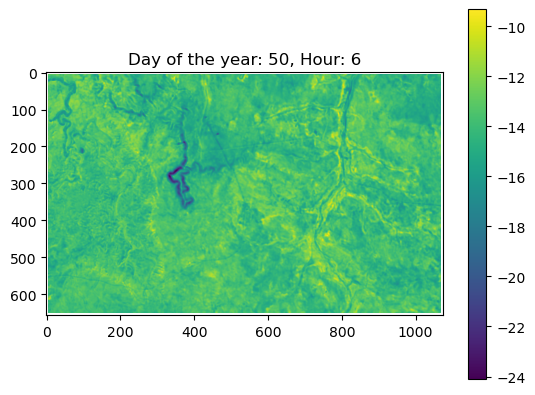

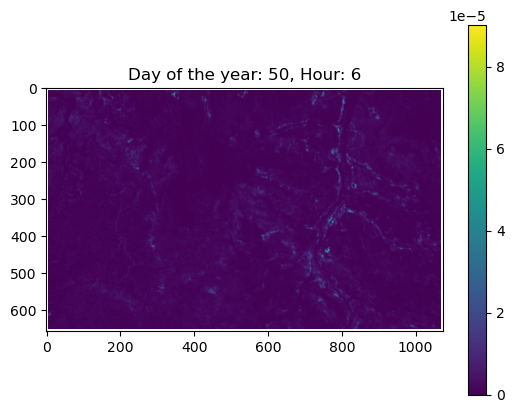

In [43]:
# Assuming the output has the shape [batch_size, channels, height, width]
# For simplicity, let's visualize the first image in the batch and its first channel
output_image = landscape_predictions[0].detach().cpu().numpy()

# Create the mask for x and y coordinates
x_mask = np.ones_like(output_image)
y_mask = np.ones_like(output_image)
water_mask = np.ones_like(output_image)

y_dim = output_image.shape[0]
x_dim = output_image.shape[1]

buffer = 3

# Create the mask for x and y coordinates
x_mask[:, :buffer] = -np.inf
x_mask[:, x_dim-buffer:] = -np.inf
y_mask[:buffer, :] = -np.inf
y_mask[y_dim-buffer:, :] = -np.inf


# mask out cells on the edges that affect the colour scale
output_image = output_image * x_mask * y_mask
# output_image[ndvi_global == -1.0] = -np.inf

# Plot the image using matplotlib
filename_landscape_preds = f"outputs/dl_prob_maps_landscape/sentinel2/{buffalo_id}/id{buffalo_id}_hab_log_prob_norm_yday{yday_t2}_hour{hour_t2}.png"
# filename_landscape_preds = f"outputs/dl_prob_maps_landscape/id{buffalo_id}_hab_log_prob_norm_{hour_t2}_{today_date}.png"
plt.imshow(output_image, cmap='viridis')  # Use 'gray' for grayscale or change as needed
plt.colorbar()  # Optional: show the color scale bar
plt.title(f'Day of the year: {yday_t2}, Hour: {hour_t2}')
plt.savefig(filename_landscape_preds, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

# Plot the image using matplotlib
filename_landscape_preds = f"outputs/dl_prob_maps_landscape/sentinel2/{buffalo_id}/id{buffalo_id}_hab_log_prob_norm_yday{yday_t2}_hour{hour_t2}.png"
# filename_landscape_preds = f"outputs/dl_prob_maps_landscape/id{buffalo_id}_hab_log_prob_norm_{hour_t2}_{today_date}.png"
plt.imshow(np.exp(output_image), cmap='viridis')  # Use 'gray' for grayscale or change as needed
plt.colorbar()  # Optional: show the color scale bar
plt.title(f'Day of the year: {yday_t2}, Hour: {hour_t2}')
plt.savefig(filename_landscape_preds, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

## Extracting values of the predictions to assess influence of landscape features

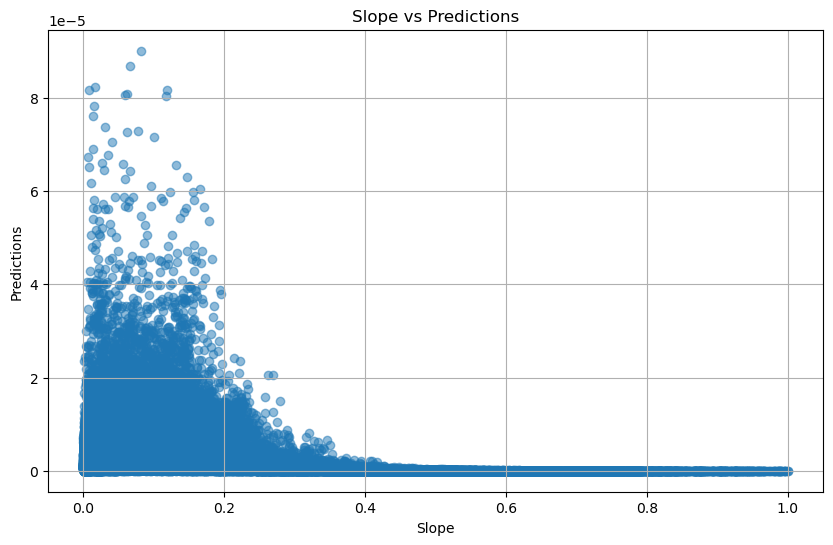

In [44]:
# Assuming ndvi_landscape, canopy_landscape, herby_landscape, slope_landscape, and landscape_predictions are already defined tensors
# Flatten the tensors and convert to numpy arrays
# ndvi_array = ndvi_landscape.detach().numpy()
# ndvi_array = ndvi_array * x_mask * y_mask
# ndvi_array = ndvi_array.flatten()

# canopy_array = canopy_landscape.detach().numpy()
# canopy_array = canopy_array * x_mask * y_mask
# canopy_array = canopy_array.flatten()

# herby_array = herby_landscape.detach().numpy()
# herby_array = herby_array * x_mask * y_mask
# herby_array = herby_array.flatten()

slope_array = slope_landscape.detach().numpy()
slope_array = slope_array * x_mask * y_mask
slope_array = slope_array.flatten()

landscape_predictions_array = torch.exp(landscape_predictions).detach().numpy()
landscape_predictions_array = landscape_predictions_array * x_mask * y_mask
landscape_predictions_array = landscape_predictions_array.flatten()


# Create a single DataFrame with updated column names
df = pd.DataFrame({
    # 'NDVI': ndvi_array,
    # 'Canopy_cover': canopy_array,
    # 'Herbaceous_vegetation': herby_array,
    'Slope': slope_array,
    'Predictions': landscape_predictions_array
})

# Export the DataFrame to a CSV file
df.to_csv(f"outputs/id{buffalo_id}_habitat_suitability_landscape_subset.csv", index=False)

# # Plot the data with plt.scatter
# plt.figure(figsize=(10, 6))
# plt.scatter(df['NDVI'], df['Predictions'], alpha=0.5)
# plt.title('NDVI vs Predictions')
# plt.xlabel('NDVI')
# plt.ylabel('Predictions')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(df['Canopy_cover'], df['Predictions'], alpha=0.5)
# plt.title('Canopy cover vs Predictions')
# plt.xlabel('Canopy cover')
# plt.ylabel('Predictions')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(df['Herbaceous_vegetation'], df['Predictions'], alpha=0.5)
# plt.title('Herbaceous vegetation vs Predictions')
# plt.xlabel('Herbaceous vegetation')
# plt.ylabel('Predictions')
# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df['Slope'], df['Predictions'], alpha=0.5)
plt.title('Slope vs Predictions')
plt.xlabel('Slope')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Together to loop over hours

In [45]:
# Initialize global min and max values
global_vmin = float('inf')
global_vmax = float('-inf')

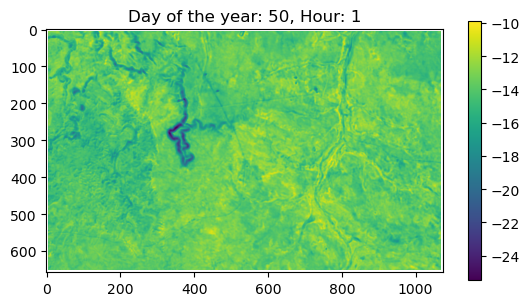

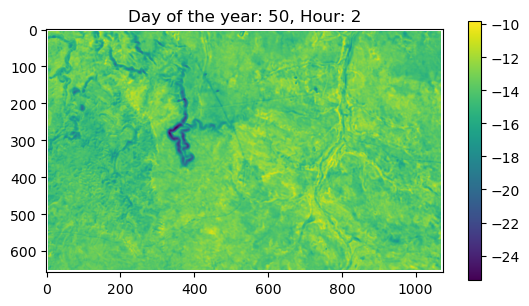

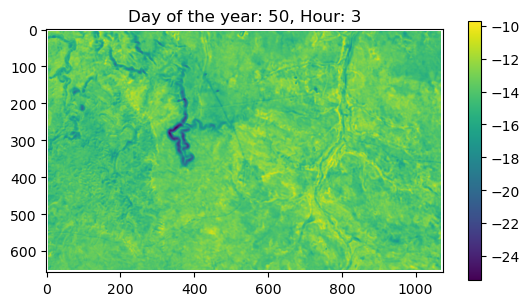

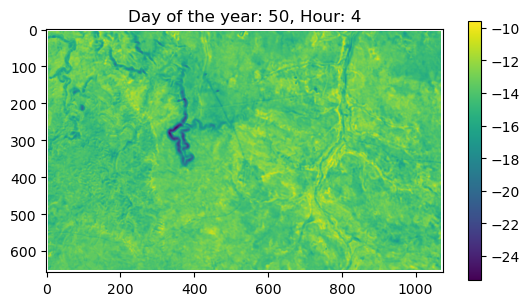

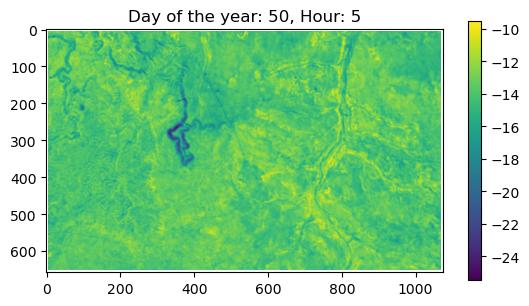

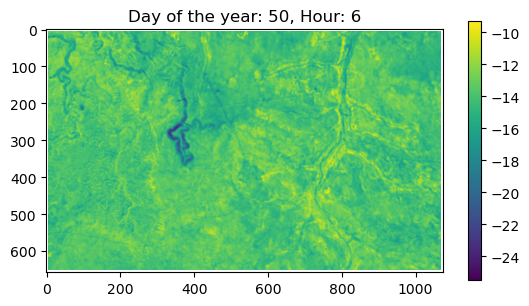

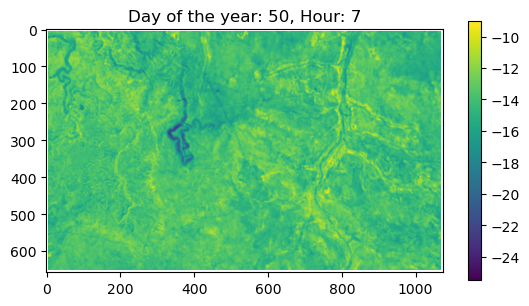

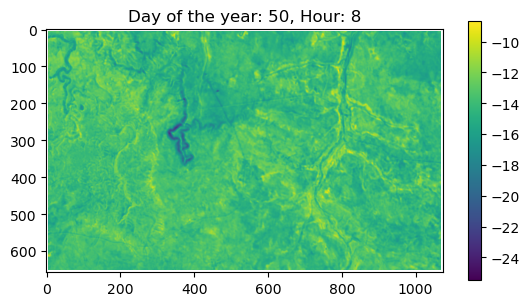

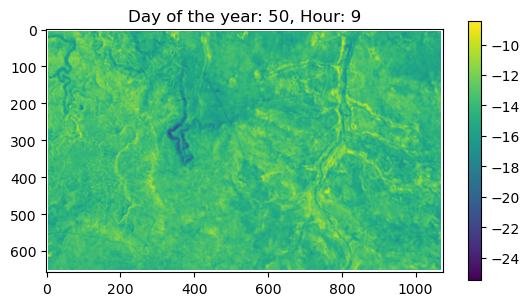

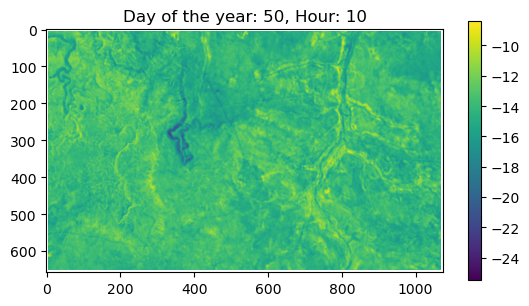

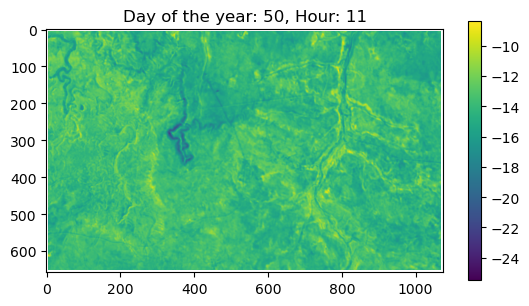

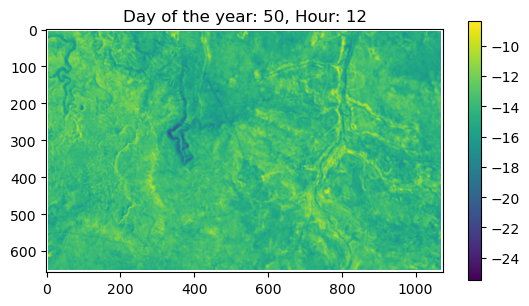

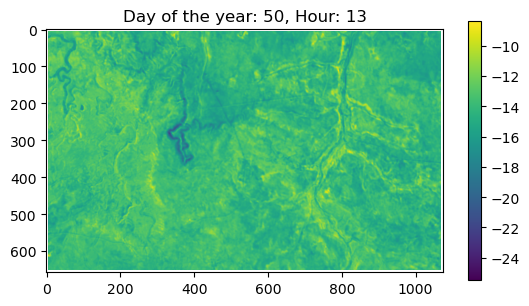

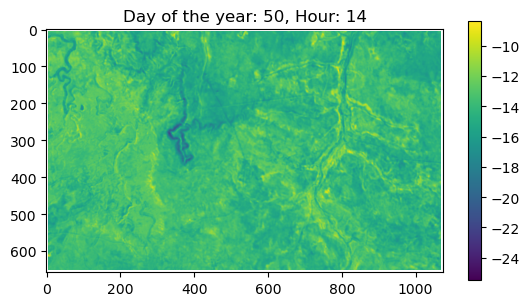

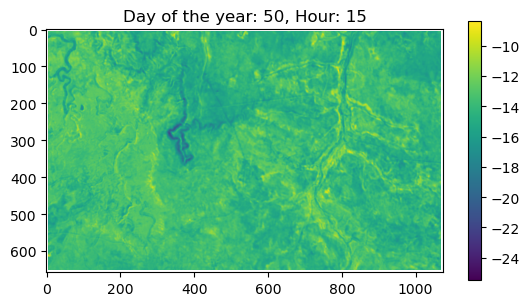

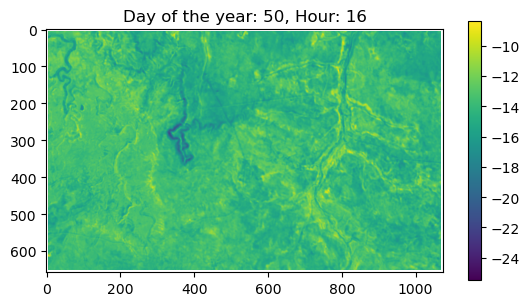

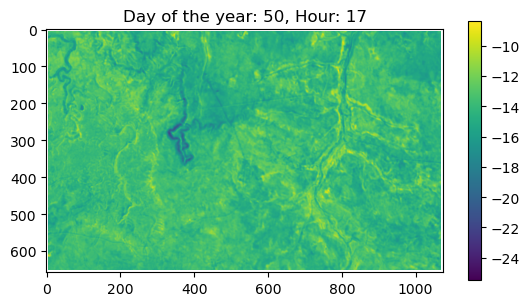

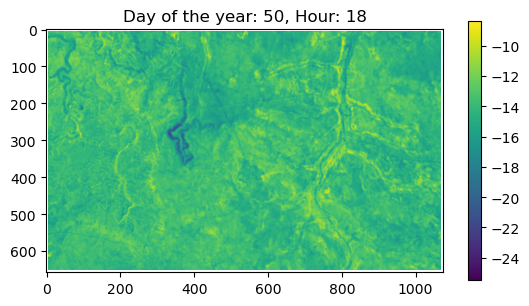

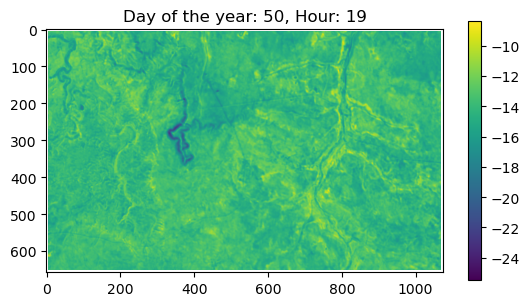

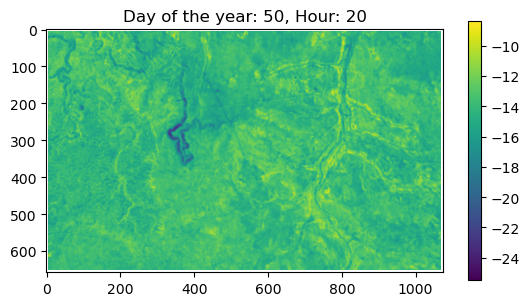

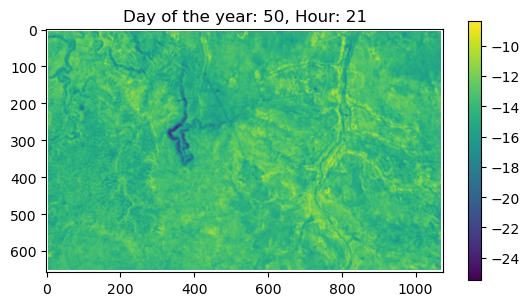

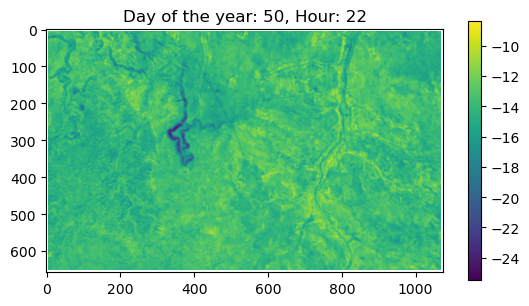

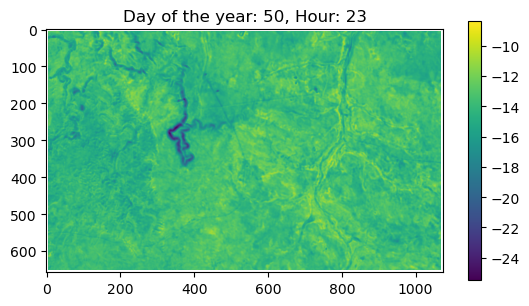

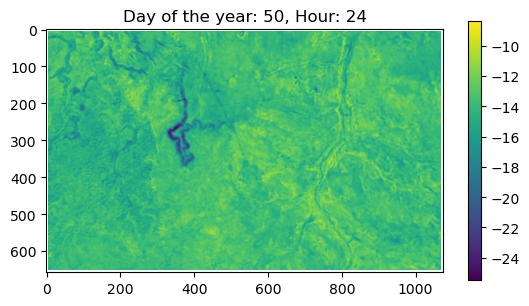

-25.483768 -8.398783


In [46]:
# # Create a single DataFrame with updated column names
# df_hourly = pd.DataFrame({
#     # 'NDVI': ndvi_array,
#     # 'Canopy_cover': canopy_array,
#     # 'Herbaceous_vegetation': herby_array,
#     'Slope': slope_array
# })

# Define the range of hours you want to loop over
hours = range(1,25) # to start at 1
# hours = np.arange(0,24, 0.1)

# Initialize lists to store results
scalar_grids_list = []
landscape_predictions_list = []

for hour_t2 in hours:
    # convert to sine and cosine
    hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
    hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

    # day of the year (yday)
    # yday_t2 = 45
    # convert to sine and cosine
    yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
    yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

    # Convert lists to PyTorch tensors
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

    # Stack tensors column-wise to create a tensor of shape 
    scalar_covariates = torch.stack([hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor], dim=0)
    scalar_grids = torch.cat([scalar_to_grid(tensor, slope_landscape.shape[0], slope_landscape.shape[1]) for tensor in scalar_covariates], dim=1)

    full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
    # print(full_stack.shape)

    landscape_predictions = model.conv_habitat(full_stack)
    # print(landscape_predictions.shape)

    # Assuming the output has the shape [batch_size, channels, height, width]
    # For simplicity, let's visualize the first image in the batch and its first channel
    output_image = landscape_predictions[0].detach().cpu().numpy()

    # mask out cells on the edges that affect the colour scale
    output_image = output_image * x_mask * y_mask

    # Check if output_image is valid before updating global min and max
    if output_image.size > 0:
        # Ignore masked values in the calculation
        valid_values = output_image[np.isfinite(output_image)]
        if valid_values.size > 0:
            current_min = valid_values.min()
            current_max = valid_values.max()
            global_vmin = min(global_vmin, current_min)
            global_vmax = max(global_vmax, current_max)

    # predictions_array = np.exp(output_image).flatten()
    # df_hourly[f'{hour_t2}'] = predictions_array

    # Save the figure
    filename_landscape_preds = f"outputs/dl_prob_maps_landscape/sentinel2/{buffalo_id}/id{buffalo_id}_landscape_habitat_selection_yday{yday_t2}_hour{hour_t2}.png"
    # filename_landscape_preds = f"outputs/dl_prob_maps_landscape/id{buffalo_id}_landscape_habitat_selection_{hour_t2}_{today_date}.png"
    plt.figure()  # Create a new figure
    # plt.imshow(output_image)
    plt.imshow(output_image, vmin=global_vmin, vmax=global_vmax)
    # plt.imshow(output_image, transform=raster_transform, vmin=global_vmin, vmax=global_vmax)
    plt.colorbar(shrink=0.7)
    plt.title(f'Day of the year: {yday_t2}, Hour: {hour_t2}')
    plt.savefig(filename_landscape_preds, dpi=1000, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

    # # Save the figure
    filename_landscape_preds = f"outputs/dl_prob_maps_landscape/sentinel2/{buffalo_id}/id{buffalo_id}_exp_landscape_habitat_selection_yday{yday_t2}_hour{hour_t2}.png"
    # filename_landscape_preds = f"outputs/dl_prob_maps_landscape/id{buffalo_id}_exp_landscape_habitat_selection_{hour_t2}_{today_date}.png"
    plt.figure()  # Create a new figure
    # plt.imshow(np.exp(output_image))
    plt.imshow(np.exp(output_image), vmin=np.exp(global_vmin), vmax=np.exp(global_vmax))
    # plt.imshow(np.exp(output_image), transform=raster_transform, vmin=np.exp(global_vmin), vmax=np.exp(global_vmax))
    plt.colorbar(shrink=0.7)
    plt.title(f'Day of the year: {yday_t2}, Hour: {hour_t2}')
    plt.savefig(filename_landscape_preds, dpi=600, bbox_inches='tight')
    # plt.show()
    plt.close()  # Close the figure to free memory

print(global_vmin, global_vmax)


# Export the DataFrame to a CSV file
# df_hourly.to_csv(f"outputs/id{buffalo_id}_hourly_habitat_suitability_landscape_subset_yday{yday_t2}.csv", index=False)

# # Randomly sample rows from the df_hourly DataFrame
# sampled_df_hourly = df_hourly.sample(frac=0.1, random_state=42)  # Adjust the fraction as needed
# # Export the sampled DataFrame to a CSV file
# sampled_df_hourly.to_csv(f"outputs/id{buffalo_id}_hourly_fine_habitat_suitability_landscape_subset.csv", index=False)